<a href="https://colab.research.google.com/github/EdithOroche/IA/blob/main/Laboratorio02_Segmentacion_Color_Sin_Mascaras_PI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio Segmentación simple a color, importancia y mejora de imágenes

In [10]:
# === Configuración del entorno ===
!pip -q install opencv-python-headless pillow ipywidgets

import cv2, numpy as np, matplotlib.pyplot as plt
from PIL import Image
import os

def show_side_by_side(imgs, titles=None, figsize=(12,4)):
    n = len(imgs)
    plt.figure(figsize=figsize)
    for i, im in enumerate(imgs, 1):
        plt.subplot(1, n, i)
        if im is None:
            plt.text(0.5, 0.5, "Imagen None", ha='center', va='center')
            plt.axis('off'); continue
        if im.ndim == 2:
            plt.imshow(im, cmap='gray')
        else:
            plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        if titles and i-1 < len(titles):
            plt.title(titles[i-1])
        plt.axis('off')
    plt.show()

print("OpenCV:", cv2.__version__, "- Entorno listo")

OpenCV: 4.12.0 - Entorno listo



## 1) Conceptos clave
- **Segmentar** es **separar** regiones relevantes según un criterio; aquí, el **color**.
- En OpenCV, las imágenes de color vienen en **BGR**; para segmentar colores suele ser mejor usar **HSV**:
  - **H (Hue/Tono):** qué color percibimos (0–179 en OpenCV).
  - **S (Saturación):** pureza del color.
  - **V (Valor/Brillo):** luminosidad.

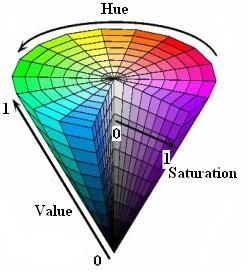

- Usaremos **indexación NumPy** para:
  - Seleccionar píxeles cuyo color esté **dentro de un rango**.
  - Modificar **directamente** esos píxeles (p. ej., subir saturación/valor, o desaturar el fondo).



## 2) Adquisición básica de imágenes
Sube 1–2 imágenes (por ejemplo, frutas, logos, objetos con color dominante).

--2025-10-07 14:56:31--  https://undetalle.com.pe/wp-content/uploads/2024/09/canasta-de-frutas-1.webp
Resolving undetalle.com.pe (undetalle.com.pe)... 89.117.116.9, 2a02:4780:27:1477:0:fc5:a5b2:3
Connecting to undetalle.com.pe (undetalle.com.pe)|89.117.116.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64224 (63K) [image/webp]
Saving to: ‘canasta-de-frutas-1.webp.1’

canasta-de-frutas-1 100%[===================>]  62.72K   272KB/s    in 0.2s    

2025-10-07 14:56:32 (272 KB/s) - ‘canasta-de-frutas-1.webp.1’ saved [64224/64224]



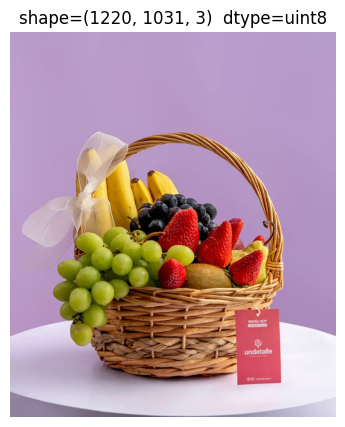

In [11]:
!wget https://undetalle.com.pe/wp-content/uploads/2024/09/canasta-de-frutas-1.webp
img = cv2.imread('canasta-de-frutas-1.webp', cv2.IMREAD_COLOR)
show_side_by_side([img], [f"shape={img.shape}  dtype={img.dtype}"], figsize=(5,5))


## 3) Segmentación simple por color con **indexación NumPy*
**Idea:** convertir la imagen a **HSV**, definir **rangos** para H, S y V, y usar una **condición booleana** para identificar píxeles del color objetivo.

**Flujo:**
1. Convertir BGR → HSV.
2. Definir rangos: `Hmin ≤ H ≤ Hmax`, `Smin ≤ S ≤ Smax`, `Vmin ≤ V ≤ Vmax`.
3. Construir una condición booleana `cond` (*array* de `True/False` del tamaño de la imagen).
4. Usar `cond` para:
   - (a) **Resaltar** el objeto (p. ej., subir saturación/valor).
   - (b) **Desaturar** u oscurecer el fondo (píxeles que **no** cumplen la condición).
5. Convertir de vuelta a BGR y visualizar.


In [12]:
import numpy as np
import cv2

def segment_and_enhance_bynumpy(
    bgr, h_range, s_range, v_range
):
    """
    Segmenta por color en HSV usando indexación NumPy.
    - Píxeles que cumplen la condición (cond): se realzan (S y V).
    - Píxeles que NO cumplen la condición: se vuelven BLANCOS (S=0, V=255).
    """

    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV).astype(np.int16)
    H, S, V = hsv[..., 0], hsv[..., 1], hsv[..., 2]

    Hmin, Hmax = h_range
    Smin, Smax = s_range
    Vmin, Vmax = v_range

    cond = (
        (H >= Hmin) & (H <= Hmax) &
        (S >= Smin) & (S <= Smax) &
        (V >= Vmin) & (V <= Vmax)
    )

    hsv_out = hsv.copy()

    # Realce en la región que cumple cond
    hsv_out[:,:, 1][cond] = np.clip(hsv_out[..., 1][cond], 0, 255)
    hsv_out[..., 2][cond] = np.clip(hsv_out[..., 2][cond], 0, 255)

    # Fondo blanco donde NO se cumple cond: S=0, V=255 (H da igual)
    hsv_out[:,:, 1][~cond] = 0
    hsv_out[..., 2][~cond] = 255

    hsv_out = np.clip(hsv_out, 0, 255).astype(np.uint8)
    bgr_out = cv2.cvtColor(hsv_out, cv2.COLOR_HSV2BGR)
    return bgr_out, cond


### 3.1 Exploración interactiva (sliders)
Ajusta los rangos HSV para aislar un color dominante y observa cómo cambia el resultado en tiempo real.

In [13]:
from ipywidgets import interact, IntSlider, Checkbox
use_widgets = True

def demo(hmin=0, hmax=20, smin=50, smax=255, vmin=50, vmax=255):
  out, cond = segment_and_enhance_bynumpy(
    img, (hmin, hmax), (smin, smax), (vmin, vmax)
  )
  show_side_by_side([img, out], ["Original", "Segmentada"])

interact(
  demo,
  hmin=IntSlider(0, 0, 179, 1), hmax=IntSlider(2, 0, 179, 1),
  smin=IntSlider(0, 0, 255, 1), smax=IntSlider(255, 0, 255, 1),
  vmin=IntSlider(0, 0, 255, 1), vmax=IntSlider(255, 0, 255, 1)
)

interactive(children=(IntSlider(value=0, description='hmin', max=179), IntSlider(value=2, description='hmax', …

<function __main__.demo(hmin=0, hmax=20, smin=50, smax=255, vmin=50, vmax=255)>

# Tarea 1:

- Copia la celda anterior y segmenta solo las uvas verdes.
- Copia la celda anterior y segmenta solo los plátanos.
- Copia la celda anterior y segmenta solo las uvas negras.
- Copia la celda anterior y segmenta solo los plátanos.
- Copia la celda anterior y segmenta solo la canasta.

TIP: Deberás usar el HUE para localizar el color, luego modificar la Saturación y Valor para mejorar la segmentación.

In [14]:
from ipywidgets import interact, IntSlider, Checkbox
use_widgets = True

def demo (hmin=20, hmax=90, smin=20, smax=255, vmin=20, vmax=255):
  out, cond = segment_and_enhance_bynumpy (
    img, (hmin, hmax), (smin, smax), (vmin, vmax)
)
  show_side_by_side([img, out], ["Original", "Uvas verdes"])

interact(
demo,
hmin=IntSlider (26, 0, 179, 1), hmax=IntSlider (85, 0, 179, 1),
smin=IntSlider (20, 0, 255, 1), smax=IntSlider(255, 0, 255, 1),
vmin=IntSlider (20, 0, 255, 1), vmax=IntSlider(255, 0, 255, 1)
)

interactive(children=(IntSlider(value=26, description='hmin', max=179), IntSlider(value=85, description='hmax'…

<function __main__.demo(hmin=20, hmax=90, smin=20, smax=255, vmin=20, vmax=255)>

In [19]:
from ipywidgets import interact, IntSlider, Checkbox
use_widgets = True

def demo (hmin=20, hmax=30, smin=100, smax=255, vmin=100, vmax=255):
  out, cond = segment_and_enhance_bynumpy (
    img, (hmin, hmax), (smin, smax), (vmin, vmax)
)
  show_side_by_side([img, out], ["Original", "Plátanos"])

interact(
demo,
hmin=IntSlider (18, 0, 179, 1), hmax=IntSlider (24, 0, 179, 1),
smin=IntSlider (100, 0, 255, 1), smax=IntSlider(255, 0, 255, 1),
vmin=IntSlider (100, 0, 255, 1), vmax=IntSlider(255, 0, 255, 1)
)

interactive(children=(IntSlider(value=18, description='hmin', max=179), IntSlider(value=24, description='hmax'…

<function __main__.demo(hmin=20, hmax=30, smin=100, smax=255, vmin=100, vmax=255)>

In [21]:
from ipywidgets import interact, IntSlider, Checkbox
use_widgets = True

def demo (hmin=120, hmax=160, smin=50, smax=255, vmin=20, vmax=150):
    out, cond = segment_and_enhance_bynumpy (
      img, (hmin, hmax), (smin, smax), (vmin, vmax)
    )
    show_side_by_side([img, out], ["Original", "Uvas negras"])

interact(
  demo,
  hmin=IntSlider(120, 0, 179, 1), hmax=IntSlider(160, 0, 179, 1),
  smin=IntSlider (30, 0, 255, 1), smax=IntSlider(255, 0, 255, 1),
  vmin=IntSlider (20, 0, 255, 1), vmax=IntSlider(150, 0, 255, 1)
)

interactive(children=(IntSlider(value=120, description='hmin', max=179), IntSlider(value=160, description='hma…

<function __main__.demo(hmin=120, hmax=160, smin=50, smax=255, vmin=20, vmax=150)>

In [23]:
from ipywidgets import interact, IntSlider, Checkbox
use_widgets = True
def demo (hmin=5, hmax=20, smin=50, smax=255, vmin=50, vmax=200):
  out, cond = segment_and_enhance_bynumpy(
    img, (hmin, hmax), (smin, smax), (vmin, vmax)
)
  show_side_by_side ([img, out], ["Original", "Canasta"])
interact(
demo,
hmin=IntSlider(8, 0, 179, 1), hmax=IntSlider (15, 0, 179, 1),
smin=IntSlider(50, 0, 255, 1), smax=IntSlider(255, 0, 255, 1),
vmin=IntSlider(50, 0, 255, 1), vmax=IntSlider (200, 0, 255, 1)
)

interactive(children=(IntSlider(value=8, description='hmin', max=179), IntSlider(value=15, description='hmax',…

<function __main__.demo(hmin=5, hmax=20, smin=50, smax=255, vmin=50, vmax=200)>

# Tarea 2

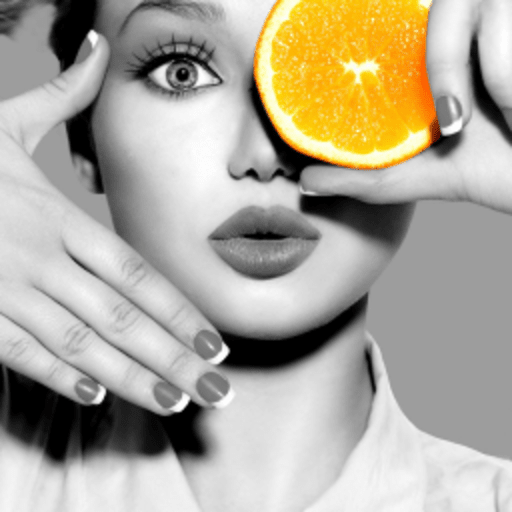

Deberás **realzar** la canasta y las frutas, **opacando** todo lo demás (fondo y mesa).

Para ello, deberás definir el rango adecuado en la línea 20 que solo capture la canasta. Y luego, resaltar S y V para los valores que cumplen esa condición y opacar S y V para los valores que no cumplen la condición.

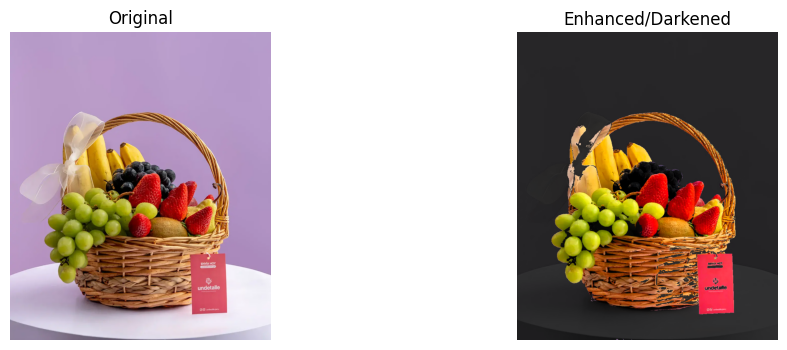

In [26]:
#Convertir a HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
#Definir rangos de frutas y canasta
mask_brown = cv2.inRange(hsv, (5, 50, 50), (20, 255, 200))
mask_yellow = cv2.inRange(hsv, (15, 80, 80), (35, 255, 255))
mask_green = cv2.inRange(hsv, (35, 80, 70), (85, 255, 255))
mask_purple = cv2.inRange(hsv, (110, 50, 20), (160, 255, 120))
mask_red1 = cv2.inRange (hsv, (0, 80, 80), (10, 255, 255))
mask_red2 = cv2.inRange (hsv, (170, 80, 80), (179, 255, 255))
mask_red = cv2.bitwise_or(mask_red1, mask_red2)
#Combinar todas las máscaras
mask = cv2.bitwise_or(mask_brown, mask_yellow)
mask = cv2.bitwise_or(mask, mask_green)
mask = cv2.bitwise_or(mask, mask_purple)
mask = cv2.bitwise_or(mask, mask_red)
#Copia del HSV
hsv_enhanced = hsv.copy()
#Realzar frutas/canasta
hsv_enhanced [:,:,1] [mask>0] = np.clip(hsv_enhanced[:,:,1] [mask>0] * 1.3, 0, 255)
hsv_enhanced [:,:,2] [mask>0] = np.clip(hsv_enhanced[:,:,2] [mask>0] * 1.2, 0, 255)
#Opaque fondo/mesa
hsv_enhanced [:,:,1] [mask==0] = hsv_enhanced[:,:,1] [mask==0] * 0.2
hsv_enhanced [:,:,2] [mask==0] = hsv_enhanced[:,:,2] [mask==0] * 0.2
# Convertir de regreso a BGR
final = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)

show_side_by_side([img, final], ["Original", "Enhanced/Darkened"])

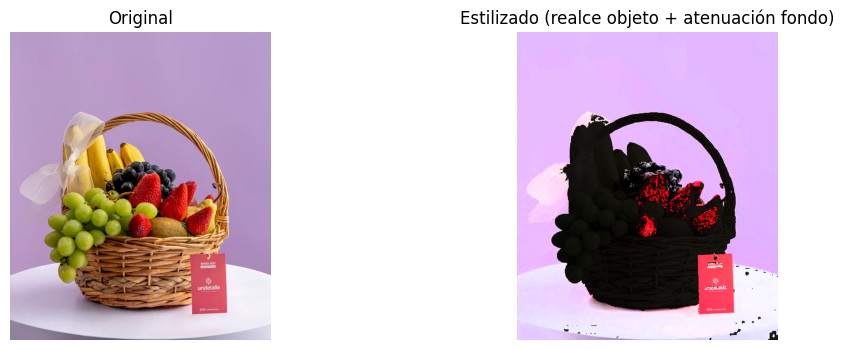

In [15]:

def stylize_object_bynumpy(bgr, h_range, s_range, v_range,
                           hue_shift=10, sat_scale=1.2, val_scale=1.15,
                           bg_sat_scale=0.3, bg_val_scale=0.8):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
    H, S, V = hsv[...,0], hsv[...,1], hsv[...,2]
    Hmin, Hmax = h_range; Smin, Smax = s_range; Vmin, Vmax = v_range
    cond = (H >= Hmin) & (H <= Hmax) & (S >= Smin) & (S <= Smax) & (V >= Vmin) & (V <= Vmax)

    S[cond] = np.clip(S[cond] * sat_scale, 0, 255)
    V[cond] = np.clip(V[cond] * val_scale, 0, 255)

    S[~cond] = np.clip(S[~cond] * bg_sat_scale, 0, 255)
    V[~cond] = np.clip(V[~cond] * bg_val_scale, 0, 255)

    hsv_out = np.stack([H, S, V], axis=-1).astype(np.uint8)
    return cv2.cvtColor(hsv_out, cv2.COLOR_HSV2BGR)

out2 = stylize_object_bynumpy(img, (0, 122), (0, 255), (0, 255),  # modificar valores
                              sat_scale=0.5, val_scale=0.1,
                              bg_sat_scale=1.2, bg_val_scale=1.75)
show_side_by_side([img, out2], ["Original", "Estilizado (realce objeto + atenuación fondo)"])


## 5) ¿Por qué segmentar por color?
- **Eficiencia:** enfoca el procesamiento en lo relevante.
- **Robustez:** reduce distracciones de fondo.
- **Preparación:** deja la imagen lista para etapas futuras (que verás en sesiones posteriores).
